In [32]:
%reload_ext autoreload
%autoreload 2
%reload_ext lab_black

In [2]:
import logging
import string
import sys
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from replay_trajectory_classification import SortedSpikesClassifier
from replay_trajectory_classification.state_transition import estimate_movement_var

from src.figure_utilities import (
    PAGE_HEIGHT,
    ONE_COLUMN,
    ONE_AND_HALF_COLUMN,
    TWO_COLUMN,
    save_figure,
    set_figure_defaults,
)
from src.parameters import (
    movement_var,
    replay_speed,
    spike_model_penalty,
    place_bin_size,
    discrete_diag,
    STATE_COLORS,
    TRANSITION_TO_CATEGORY,
)

set_figure_defaults()

In [3]:
from dask.distributed import Client

client = Client(n_workers=16)

client

Client Scheduler: tcp://127.0.0.1:33675 Dashboard: http://127.0.0.1:44651/status,Cluster Workers: 16 Cores: 64 Memory: 1.62 TB


In [4]:
from replay_trajectory_classification import SortedSpikesClassifier
from src.sorted_spikes_simulation import (
    make_hover_continuous_fragmented_replay,
    make_simulated_run_data,
    SAMPLING_FREQUENCY,
)

(
    time,
    linear_distance,
    sampling_frequency,
    spikes,
    place_fields,
) = make_simulated_run_data()

replay_time, test_spikes = make_hover_continuous_fragmented_replay()
replay_time *= SAMPLING_FREQUENCY

In [5]:
from tqdm.autonotebook import tqdm

# discrete_transition_diag = [
#     1 / 3,
#     0.4,
#     0.5,
#     0.6,
#     0.7,
#     0.8,
#     0.9,
#     0.99,
#     0.999,
#     0.9999,
#     0.99999,
#     0.999999,
#     0.9999999,
#     0.99999999,
#     0.9999999999,
#     1.0,
# ]

durations = [
    0.002,
    0.010,
    0.025,
    0.050,
    0.075,
    0.100,
    0.150,
    0.200,
    0.300,
    0.500,
    1.0,
    np.inf,
]  # in seconds

discrete_transition_diag = [
    1 - (1 / (duration * SAMPLING_FREQUENCY)) for duration in durations
]

results = []

for diag in tqdm(discrete_transition_diag):

    classifier = SortedSpikesClassifier(
        movement_var=movement_var,
        replay_speed=replay_speed,
        spike_model_penalty=spike_model_penalty,
        place_bin_size=place_bin_size,
        discrete_transition_diag=diag,
    )
    classifier.fit(linear_distance, spikes)

    results.append(
        classifier.predict(test_spikes, time=replay_time).assign_coords(
            state=lambda ds: ds.state.to_index().map(TRANSITION_TO_CATEGORY)
        )
    )

In [6]:
from src.analysis import get_is_classified, get_probability
from src.parameters import PROBABILITY_THRESHOLD


def plot_spikes(test_spikes, replay_time, ax=None):
    if ax is None:
        ax = plt.gca()
    spike_ind, neuron_ind = np.nonzero(test_spikes)

    ax.eventplot(
        replay_time[spike_ind][:, np.newaxis],
        lineoffsets=neuron_ind + 1,
        colors="black",
        linewidth=1,
        clip_on=False,
        zorder=-1,
        alpha=0.5,
    )
    ax.set_yticks([])
    ax.set_ylim((1, test_spikes.shape[1]))
    ax.set_xlim((replay_time.min(), replay_time.max() + 1))
    ax.set_xticks((replay_time.min(), replay_time.max() + 1))
    sns.despine(offset=5, ax=ax)


def plot_probabilities(results, ax=None):
    if ax is None:
        ax = plt.gca()
    probabilities = results.acausal_posterior.sum("position").values

    for probability, state in zip(probabilities.T, results.state.values):
        ax.plot(
            results.time,
            probability,
            linewidth=1,
            label=state,
            color=STATE_COLORS[state],
            clip_on=False,
            zorder=10,
        )
    xlim = results.time.min(), results.time.max() + 1
    ax.set_xticks(xlim)
    ax.set_xlim(xlim)
    ax.set_yticks([0, 1])
    ax.set_ylim([0, 1])
    ax.set_title("Probability of\nMovement Dynamic", fontsize=16)

    is_classified = get_is_classified(get_probability(results), PROBABILITY_THRESHOLD)
    for state, is_class in zip(is_classified.state.values, is_classified.values.T):
        if is_class.sum() > 0:
            ax.fill_between(
                results.time,
                is_class,
                where=is_class.astype(bool),
                alpha=0.25,
                color=STATE_COLORS[state],
            )
    sns.despine(offset=5, ax=ax)

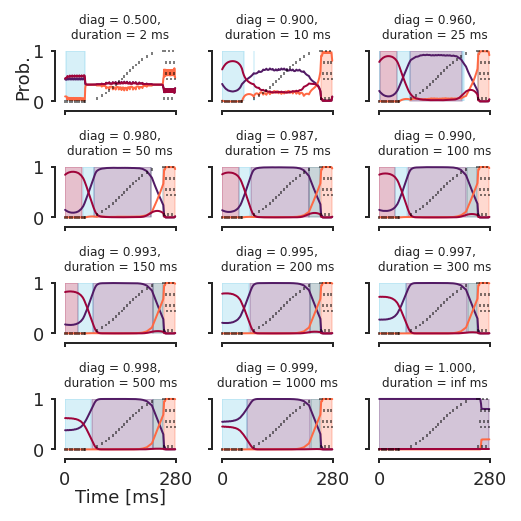

In [39]:
fig, axes = plt.subplots(
    nrows=4,
    ncols=3,
    figsize=(ONE_COLUMN, ONE_COLUMN),
    sharex=True,
    sharey=True,
    constrained_layout=True,
)

for ax, duration, diag, result in zip(
    axes.flat, durations, discrete_transition_diag, results
):
    plot_probabilities(result, ax=ax)
    plot_spikes(test_spikes, replay_time, ax=ax.twinx())
    ax.set_title(f"diag = {diag:0.3f},\nduration = {duration*1000:0.0f} ms", fontsize=6)

axes[0, 0].set_ylabel("Prob.")
axes[-1, 0].set_xlabel("Time [ms]")
save_figure(
    os.path.join(
        "Figure1-supplemental1", "figure1_supplemental1_changing_discrete_diagonal"
    )
)

In [14]:
def plot_posterior(
    classifier,
    results,
    linear_distance,
    ax=None,
    cbar_orientation="vertical",
    cbar_aspect=50,
):
    if ax is None:
        ax = plt.gca()

    posterior = results.acausal_posterior.sum("state")
    posterior.plot(
        x="time",
        y="position",
        vmin=0.0,
        robust=True,
        rasterized=True,
        ax=ax,
        add_colorbar=False,
        cmap="bone_r",
    )
    ax.set_ylabel("")
    ax.set_xlabel("")
    xlim = results.time.min(), results.time.max() + 1
    ax.set_xticks(xlim)
    ax.set_xlim(xlim)

    ylim = linear_distance.min(), linear_distance.max()
    ax.set_yticks(ylim)
    ax.set_ylim(ylim)
    sns.despine(offset=5)

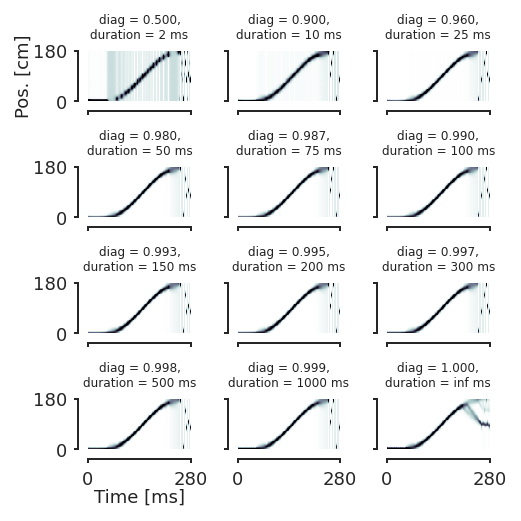

In [41]:
fig, axes = plt.subplots(
    nrows=4,
    ncols=3,
    figsize=(ONE_COLUMN, ONE_COLUMN),
    sharex=True,
    sharey=True,
    constrained_layout=True,
)

for ax, duration, diag, result in zip(
    axes.flat, durations, discrete_transition_diag, results
):
    plot_posterior(
        classifier,
        result,
        linear_distance,
        ax=ax,
        cbar_orientation="vertical",
        cbar_aspect=50,
    )
    ax.set_title(f"diag = {diag:0.3f},\nduration = {duration*1000:0.0f} ms", fontsize=6)

axes[0, 0].set_ylabel("Pos. [cm]")
axes[-1, 0].set_xlabel("Time [ms]")
save_figure(
    os.path.join(
        "Figure1-supplemental1",
        "figure1_supplemental1_changing_discrete_diagonal_posterior",
    )
)

In [10]:
client.close()